In [1]:
%%bash
pip install pyspark

if [[ ! -f ./train.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
fi

if [[ ! -f ./test.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/test.csv  
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=c7f84018f99d2f3eae55d65bb69f4f02946d84aa50a5768074f667ab4f74b1b9
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-13 11:33:28--  https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21432357 (20M) [text/plain]
Saving to: ‘train.csv’

     0K .......... .......... .......... .......... ..........  0% 4.06M 5s
    50K .......... .......... .......... .......... ..........  0% 10.5M 3s
   100K .......... .......... .......... .......... ..........  0% 4.85M 4s
   150K .......... .......... .......... .......... ..........  0% 17.0M 3s
   200K .......... .......... .......... .......... ..........  1% 6.61M 3s
   250K .......... .......... .......... .......... ..........  1% 54.9M 3s
   300K .......... .......... .......... .......... ..........  1% 22.1M 2s
   350K ...

In [2]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as fn

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [3]:
train = spark.read.csv('train.csv', inferSchema=True, header=True)
test = spark.read.csv('test.csv', inferSchema=True, header=True)

In [4]:
train.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
test.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [6]:
print(train.toPandas().shape, test.toPandas().shape)

(381109, 12) (127037, 11)


In [7]:
# checking for NAs
train.select([fn.count(fn.when(fn.isnull(c) | fn.isnan(c), c)).alias(c) for c in train.columns]).show()

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  0|     0|  0|              0|          0|                 0|          0|             0|             0|                   0|      0|       0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of the target variable - Response')

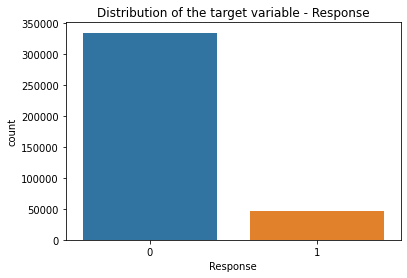

In [8]:
ax = sns.countplot(train.select('Response').toPandas()['Response'])
ax.set_title('Distribution of the target variable - Response')

Classes are heavily imbalanced.

Although <i>Region_Code</i> and <i>Policy_Sales_Channel</i> are categorical variables, for exploratory analysis, it is easier to treat them as numerical variables.

In [9]:
numerical_columns=['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
categorical_columns=['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']

In [10]:
train[numerical_columns].describe().show()

+-------+------------------+------------------+------------------+--------------------+------------------+
|summary|               Age|       Region_Code|    Annual_Premium|Policy_Sales_Channel|           Vintage|
+-------+------------------+------------------+------------------+--------------------+------------------+
|  count|            381109|            381109|            381109|              381109|            381109|
|   mean|38.822583565331705|26.388807401557035|30564.389581458323|  112.03429465061177|154.34739667654136|
| stddev|15.511611018095289| 13.22988802578849| 17213.15505698001|   54.20399477485634| 83.67130362658735|
|    min|                20|               0.0|            2630.0|                 1.0|                10|
|    max|                85|              52.0|          540165.0|               163.0|               299|
+-------+------------------+------------------+------------------+--------------------+------------------+



Statistical summary observations -<br>
The min, mean and max values for each numerical variable are comparable, which reduces the possibility of erroneous data (the data is clean, no clear outliers).<br>
The scales of different variables are clearly different and scaling might be required for certain algorithms.

Text(0.5, 1.01, 'Train data pair plot')

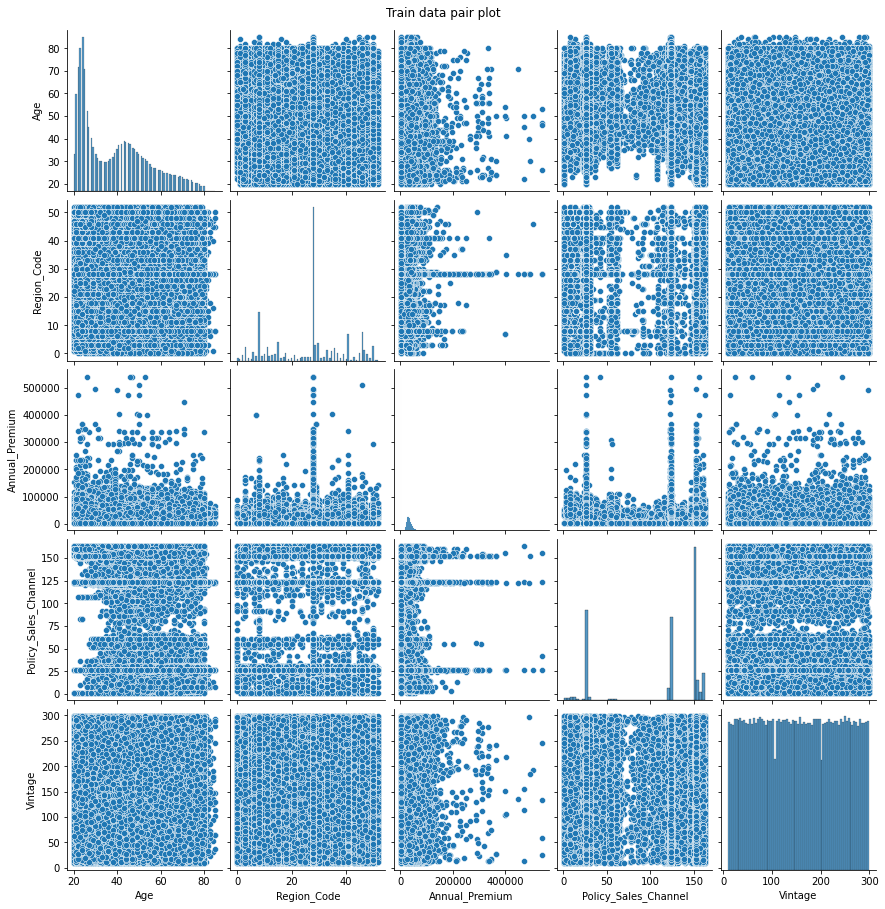

In [11]:
ax = sns.pairplot((train[numerical_columns]).toPandas())
ax.fig.suptitle('Train data pair plot', y=1.01)

Pair plot observations -<br>
There doesn't seem to be any correlation between the numerical variables.<br>
<i>Annual_Premium</i> is heavily left skewed.<br>
<i>Age</i> is left skewed.

In [12]:
# prints the counts of the categories in the column
def count_categorical(column):
  train.groupBy(column).count().show()

In [13]:
list(map(count_categorical, categorical_columns))

+------+------+
|Gender| count|
+------+------+
|Female|175020|
|  Male|206089|
+------+------+

+---------------+------+
|Driving_License| count|
+---------------+------+
|              1|380297|
|              0|   812|
+---------------+------+

+------------------+------+
|Previously_Insured| count|
+------------------+------+
|                 1|174628|
|                 0|206481|
+------------------+------+

+-----------+------+
|Vehicle_Age| count|
+-----------+------+
|  > 2 Years| 16007|
|   < 1 Year|164786|
|   1-2 Year|200316|
+-----------+------+

+--------------+------+
|Vehicle_Damage| count|
+--------------+------+
|            No|188696|
|           Yes|192413|
+--------------+------+

+--------+------+
|Response| count|
+--------+------+
|       1| 46710|
|       0|334399|
+--------+------+



[None, None, None, None, None, None]

In [14]:
# plots the counts of the categories in the column with the target variable
def plot_categorical(column):
  plot_df = train.groupBy(column, 'Response').count().toPandas()
  ax = sns.catplot(x=column, y='count', col='Response', data=plot_df, kind='bar', height=4, aspect=.7)
  ax.fig.suptitle('Distribution of {} with Response'.format(column), y=1.01)

[None, None, None, None, None]

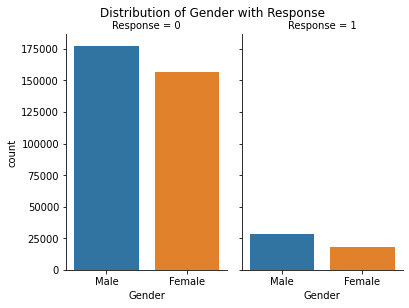

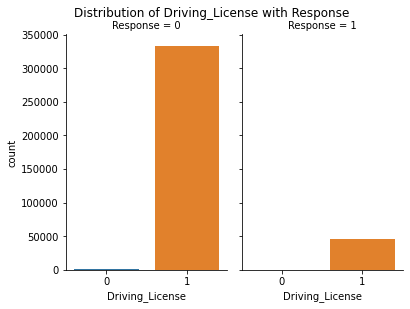

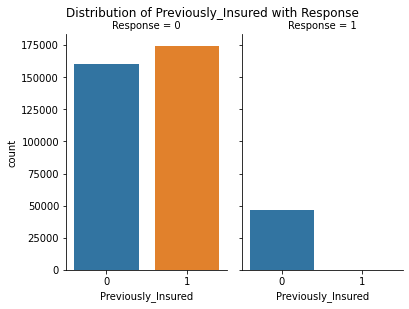

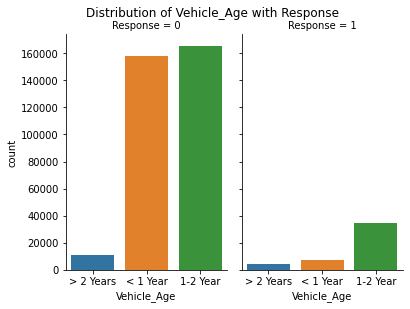

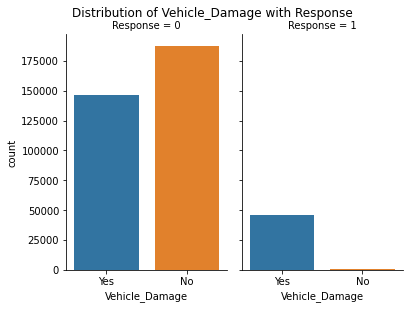

In [15]:
list(map(plot_categorical, categorical_columns[:-1]))

All interested customers (Response=1) have a driving license (Driving_License=1) and already have a vehicle insurance (Previously_Insured=1), and almost all of them have damaged their vehicle in the past (Vehicle_Damaged=Yes). These 3 columns have high predictive power.